# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [149]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [150]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [151]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [152]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [153]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [154]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [155]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [364]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [365]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [366]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [367]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [368]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [369]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

In [370]:
final['Score'].value_counts()

1    293516
0     54744
Name: Score, dtype: int64

In [371]:
pos_reviews=final[final['Score']== 1].sample(n=50000)
neg_reviews=final[final['Score']== 0].sample(n=50000)
a=(pos_reviews,neg_reviews)
final=pd.concat(a)

# FEATURE ENGINEERING

In [372]:
#Concating both the summary and text inorder to improve the model and then using it to test the model

#https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python

final['TEXT_SUMMARY']=final['Text'] +" "+ final["Summary"]

final=final.sort_values(by='Time')



final['TEXT_SUMMARY'][:1]==(final['Text'][:1]+" "+final['Summary'][:1])


346041    True
dtype: bool

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [373]:
# printing some random reviews
sent_0 =final['TEXT_SUMMARY'].values[0]


sent_1000 =final['TEXT_SUMMARY'].values[1000]


sent_1500 =final['TEXT_SUMMARY'].values[1500]


sent_4900 =final['TEXT_SUMMARY'].values[4900]


# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()


soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

sent_1500 = decontracted(sent_1500)


#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()


#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)


# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

I, myself always enjoyed this movie, it's very funny and entertaining, so I didn't hesitate to pick up the clamshell edition.  I guess it was a marketing plan to make the movie more for families or something, but they  have eliminated all strong profanity and elements that are usually edited  in the television version.  YOU HAVE BEEN WARNED.  If you want the uncut  version, AVOID THE CLAMSHELL EDITION! WARNING: CLAMSHELL EDITION IS EDITED TV VERSION


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [01:42<00:00, 976.22it/s]


In [374]:
preprocessed_reviews[1500]

'redeeming qualities not needing refrigeration cooking cook minutes great quick meal side dish butter tomato sauce gnocchi not greatest like starchy dumplings heavy dough no potato texture taste'

In [375]:
import pickle
with open("final['Score'].pkl",'wb') as f:
    pickle.dump(final['Score'],f)

with open("preprocessed_reviews.pkl",'wb') as f:
    pickle.dump(preprocessed_reviews,f)


# [4] Featurization

In [376]:
len(preprocessed_reviews)

100000

In [377]:
len(final['Score'])

100000

In [529]:
# SPLITTING THE DATA INTO TEST TRAIN AND CV

y_train= final['Score'][:10000]
y_cv=    final['Score'][10000:15000]
y_test=  final['Score'][15000:20000]

x_train= preprocessed_reviews[:10000]
x_cv=    preprocessed_reviews[10000:15000]
x_test=  preprocessed_reviews[15000:20000]



## [4.1] BAG OF WORDS

In [530]:
print("VECTOR OF THE TEXT AND SUMMARY")
print("-------------------------------------------")
#train_BoW

count_vect = CountVectorizer(min_df=10, max_features=500) #in scikit-learn
train_bow  = count_vect.fit_transform(x_train )
print("the type of count vectorizer ",type(train_bow ))
print("the shape of out text BOW vectorizer ",train_bow .get_shape())
print("the number of unique words ", train_bow .get_shape()[1])
print("********************************************")
#cv_BoW
cv_bow  = count_vect.transform(x_cv )
print("the type of count vectorizer ",type(cv_bow ))
print("the shape of out text BOW vectorizer ",cv_bow .get_shape())
print("the number of unique words ", cv_bow .get_shape()[1])
#cv_BoW
#cv_BoW
test_bow  = count_vect.transform(x_test )
print("the type of count vectorizer ",type(test_bow ))
print("the shape of out text BOW vectorizer ",test_bow .get_shape())
print("the number of unique words ", test_bow .get_shape()[1])


VECTOR OF THE TEXT AND SUMMARY
-------------------------------------------
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 500)
the number of unique words  500
********************************************
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 500)
the number of unique words  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 500)
the number of unique words  500




## [4.2] Bi-Grams and n-Grams.

In [532]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (100000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [533]:
print("VECTOR OF TEXT AND SUMMARY")
print("                                  ")
#tfidf_train
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
train_tf_idf = tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(train_tf_idf))
print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])
# tfidf_test
test_tf_idf = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(test_tf_idf))
print("the shape of out text TFIDF vectorizer ",test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", test_tf_idf.get_shape()[1])

# tdidf_cv
cv_tf_idf = tf_idf_vect.transform(x_cv)
print("the type of count vectorizer ",type(cv_tf_idf))
print("the shape of out text TFIDF vectorizer ",cv_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", cv_tf_idf.get_shape()[1])

VECTOR OF TEXT AND SUMMARY
                                  
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10000, 500)
the number of unique words including both unigrams and bigrams  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 500)
the number of unique words including both unigrams and bigrams  500
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] AVG Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_cv:
    list_of_sentance.append(sentance.split())

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())
                            

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

## TFIDF-W2V

In [ ]:
## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
                            

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
list=[]
for i in model.idf_:
    list.append(i)
dictionary = dict(zip(model.get_feature_names(), list))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_cv:
    list_of_sentance.append(sentance.split())
                            

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_cv)
# we are converting a dictionary with word as a key, and the idf as a value
list=[]
for i in model.idf_:
    list.append(i)
dictionary = dict(zip(model.get_feature_names(), list))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

## [4.4] Word2Vec

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())
                            

list=[]
w2v_words_dict = (w2v_model.wv.vocab)
w2v_words=w2v_words_dict.keys()
list=[]
print("number of words that occured minimum 5 times ",len(w2v_words))
for i in w2v_words:
    list.append(i)
print("sample words ", list[0:50])


# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
list=[]
for i in model.idf_:
    list.append(i)
dictionary = dict(zip(model.get_feature_names(), list))

# TF-IDF weighted Word2Vec
Tfidf_feat = model.get_feature_names() # Tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = Tfidf

Tfidf_sent_vectors_test = []; # the Tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in Tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, Tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [537]:
from sklearn.preprocessing import StandardScaler 
scaler= StandardScaler(with_mean=False)
train_bow = scaler.fit_transform (train_bow)
cv_bow=scaler.transform(cv_bow)
test_bow=scaler.transform(test_bow)

In [538]:
scaler= StandardScaler(with_mean=False)
train_tf_idf = scaler.fit_transform(train_tf_idf)
cv_tf_idf=scaler.transform(cv_tf_idf)
test_tf_idf=scaler.transform(test_tf_idf)

In [539]:
scaler= StandardScaler()
sent_vectors_train = scaler.fit_transform(sent_vectors_train)
sent_vectors_cv=scaler.transform(sent_vectors_cv)
sent_vectors_test=scaler.transform(sent_vectors_test)

In [540]:
scaler= StandardScaler()

tfidf_sent_vectors_cv=scaler.fit_transform(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test=scaler.transform(Tfidf_sent_vectors_test)
tfidf_sent_vectors_train=scaler.transform(tfidf_sent_vectors_train)

# Applying SVM

## [5.1] Linear kernel

In [439]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
import math
from sklearn.calibration import CalibratedClassifierCV
from  sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score

def SimpleCrossValidation(x_train,x_cv,pred_train_data,pred_cv_data,x_test):
    print("AFTER FEATURE ENGINEERING")
    list_train=[]
    list_cv=[]

    alpha=.00001
    ALPHA=[]
    while (alpha<1000):
        ALPHA.append(math.ceil(math.log(alpha,10)))
       
        clf = SGDClassifier(loss='hinge',penalty='l2',alpha=alpha,class_weight='balanced')
        # fitting the model on crossvalidation traincc
        clf.fit(x_train, y_train)
         
        #calibrate model on validation data
        clf=CalibratedClassifierCV(clf,cv='prefit')
        clf.fit(x_cv,y_cv)  
         
        predicted_train=[]
        pred_train=[]
        predicted_cv=[]
        pred_cv=[]
        # predict the response on the train 
       
        for j in range(0,60000,1000):
                predicted_train =clf.predict_proba(pred_train_data[j:(j+1000)])
                pred_train.extend(predicted_train[:,1])

        # predict the response on the crossvalidation 
        
        for j in range(0,20000,1000):
                predicted_cv =clf.predict_proba(pred_cv_data[j:(j+1000)])
                pred_cv.extend(predicted_cv[:,1])
        alpha*=10

        # evaluate train accuracy
        auc_train=roc_auc_score(y_train,pred_train)
        #print('AUC train SCORE  FOR', alpha ,'is', auc_train*100)
        list_train.append(auc_train)
    
     
        # evaluate cv accuracy
        auc_cv=roc_auc_score(y_cv,pred_cv)  
        print('AUC cv SCORE  FOR', alpha ,'is', auc_cv*100)
        list_cv.append(auc_cv)
        list_cv_max=max(list_cv)

    print("="*50)
    print("train AUC SCORE",list_train)
    pred_train=pred_train
    print("="*50)
    print(" MAX CV AUC SCORE",list_cv_max*100)
    pred_cv=pred_cv
    #pred_test=predict_test(x_test,x_train)
    
    return list_train,list_cv,pred_train,pred_cv,ALPHA,pred_test,clf
        

In [254]:
def AUCcurve(y1,y2):
    
    x=ALPHA
    plt.xlabel('hyperparameter')
    plt.ylabel('AREA UNDER GRAPH')
    plt.title("auc of train and cv data")
    plt.plot(x,y1,'y', label='train')
    plt.plot(x,y2, 'r',label='cv' )
    plt.legend()
    plt.show()

In [255]:
# ROC FOR TRAIN AND TEST TFIDF
def ROC_curve(pred_train,pred_test):
    plt.title('Receiver Operating Characteristic  after feature engineering')
    fbr_train,tpr_train,thresholds=metrics.roc_curve(y_train,pred_train)
    roc_auc=metrics.auc(fbr_train,tpr_train)
    fbr_test,tpr_test,thresholds=metrics.roc_curve(y_test,pred_test)
    roc_auc=metrics.auc(fbr_test,tpr_test)
    plt.plot(fbr_test,tpr_test,'b',label="roc_auc of test")
    plt.legend()
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.plot(fbr_train,tpr_train,'r',label="roc_auc of train")
    plt.legend(loc='lower right')
    plt.show()


In [256]:
# CONFUSION MATRIX FOR TFIDF
def confusion(pred_test):
    confusion_tf_idf2=confusion_matrix(y_test,pred_test)
    plt.figure(figsize=[8,6])
    sns.heatmap(confusion_tf_idf2,annot=True,annot_kws={'size':16},fmt='g')
    plt.title("confusion matrix for tf_idf after feature engineering")
    plt.xlabel("Predicted values")
    plt.ylabel("Actual Value")
    plt.show()

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [403]:
list_train,list_cv,pred_train,pred_cv,ALPHA,pred_test,clf=SimpleCrossValidation(x_test=test_bow,x_train=train_bow,x_cv=cv_bow,pred_train_data=train_bow,pred_cv_data=cv_bow)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 0.0001 is 91.94434893693678
AUC cv SCORE  FOR 0.001 is 93.15002625278031
AUC cv SCORE  FOR 0.01 is 94.17033328434746
AUC cv SCORE  FOR 0.1 is 93.09242483364558
AUC cv SCORE  FOR 1.0 is 88.42498677296086
AUC cv SCORE  FOR 10.0 is 79.45810853506387
AUC cv SCORE  FOR 100.0 is 74.28610499072967
AUC cv SCORE  FOR 1000.0 is 74.28610499072967
train AUC SCORE [0.9564679913670768, 0.9636798726012863, 0.96061029318162, 0.9387314791885946, 0.8852735090859909, 0.7948341930239564, 0.7450192556364992, 0.7450192556364992]
 MAX CV AUC SCORE 94.17033328434746


In [406]:
 clf = SGDClassifier(loss='hinge',penalty='l2',alpha=alpha,class_weight='balanced')
# AUC VALUE FOR BEST HYPERPARAMETER
clf = SGDClassifier(alpha=.01)
clf.fit(train_bow, y_train)
#calibrate model on validation data
clf=CalibratedClassifierCV(clf,cv='prefit')
clf.fit(cv_bow,y_cv)  
pred_test_bow= (clf.predict_proba(test_bow))[:,1]
auc_test=roc_auc_score(y_test,pred_test_bow)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(test_bow)

AUC VALUE FOR TEST DATA 86.67712360162967


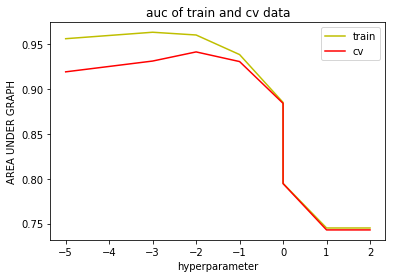

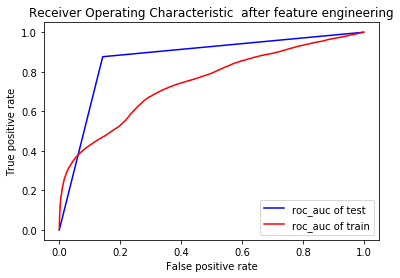

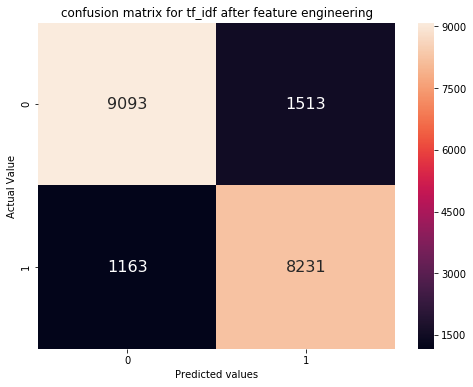

In [407]:
AUCcurve(y1=list_train,y2=list_cv)
ROC_curve(pred_train,pred_test)
confusion(pred_test)

In [408]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))


In [409]:
show_most_informative_features(count_vect, clf, n=10)

	-0.0637	recommended    		0.1923	single         
	-0.0580	new            		0.1237	starbucks      
	-0.0577	still          		0.1237	soup           
	-0.0337	taste like     		0.0990	box            
	-0.0173	green tea      		0.0737	popcorn        
	-0.0170	end            		0.0720	terrible       
	-0.0140	not buy        		0.0613	crackers       
	-0.0137	saw            		0.0587	soy            
	-0.0130	available      		0.0380	son            
	-0.0123	us             		0.0377	could          


### [5.1.4]  Applying Linear SVM on TFIDF ,<font color='red'> SET 2</font>

In [411]:
list_train,list_cv,pred_train,pred_cv,ALPHA,pred_test,clf=SimpleCrossValidation(x_train=train_tf_idf,x_cv=cv_tf_idf,pred_train_data=train_tf_idf,pred_cv_data=cv_tf_idf,x_test=test_tf_idf)


AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 0.0001 is 96.72134141436052
AUC cv SCORE  FOR 0.001 is 95.69379067471169
AUC cv SCORE  FOR 0.01 is 92.00940643352999
AUC cv SCORE  FOR 0.1 is 90.95886243125435
AUC cv SCORE  FOR 1.0 is 90.95886243125435
AUC cv SCORE  FOR 10.0 is 90.95886243125435
AUC cv SCORE  FOR 100.0 is 90.95886243125435
AUC cv SCORE  FOR 1000.0 is 90.95886243125435
train AUC SCORE [0.9994566007776092, 0.977609475574754, 0.9285205864203658, 0.9168477176151941, 0.9168477176151941, 0.9168477176151941, 0.9168477176151941, 0.9168477176151941]
 MAX CV AUC SCORE 96.72134141436052


In [414]:
# AUC VALUE FOR BEST HYPERPARAMETER
clf = SGDClassifier(alpha=.0001)
clf.fit(train_tf_idf, y_train)
#calibrate model on validation data
clf=CalibratedClassifierCV(clf,cv='prefit')
clf.fit(cv_tf_idf,y_cv)  
pred_test_tf_idf= (clf.predict_proba(test_tf_idf))[:,1]
auc_test=roc_auc_score(y_test,pred_test_tf_idf)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(test_tf_idf)

AUC VALUE FOR TEST DATA 89.15000390835287


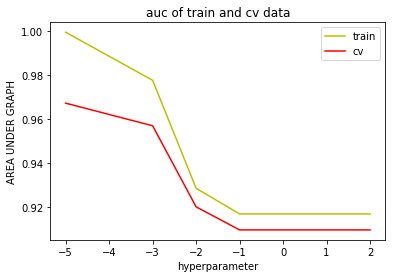

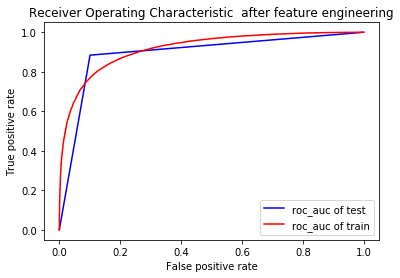

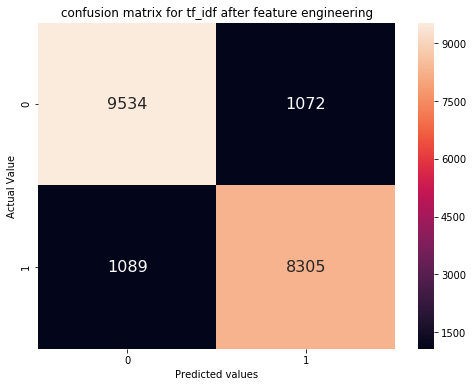

In [415]:
AUCcurve(y1=list_train,y2=list_cv)
ROC_curve(pred_train,pred_test)
confusion(pred_test)

In [416]:
show_most_informative_features(tf_idf_vect, clf, n=10)

	-7.0525	not            		7.5932	great          
	-5.1156	disappointed   		6.2286	best           
	-3.8897	worst          		5.6212	delicious      
	-3.8805	not good       		5.2133	good           
	-3.6627	bad            		4.9333	love           
	-3.4999	thought        		4.5166	perfect        
	-3.4674	terrible       		4.3672	loves          
	-3.3964	disappointing  		4.2764	excellent      
	-3.3841	unfortunately  		3.9211	wonderful      
	-3.3830	awful          		3.8013	nice           


### [5.1.3]  Applying Linear SVM on AVG-W2V,<font color='red'> SET 3</font>

In [419]:
list_train,list_cv,pred_train,pred_cv,ALPHA,pred_test,clf=SimpleCrossValidation(x_test=sent_vectors_test,x_train=sent_vectors_train,x_cv=sent_vectors_cv,pred_train_data=sent_vectors_train,pred_cv_data=sent_vectors_cv)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 0.0001 is 90.45415805199349
AUC cv SCORE  FOR 0.001 is 91.44816147552875
AUC cv SCORE  FOR 0.01 is 91.757079406148
AUC cv SCORE  FOR 0.1 is 91.5617106508305
AUC cv SCORE  FOR 1.0 is 90.85112070289311
AUC cv SCORE  FOR 10.0 is 89.68189040067368
AUC cv SCORE  FOR 100.0 is 89.47985465600887
AUC cv SCORE  FOR 1000.0 is 89.47984559759942
train AUC SCORE [0.9028271072247314, 0.9134664205877008, 0.9169885399172394, 0.9152790991168598, 0.9085661679449599, 0.8955179954015877, 0.8942434828843824, 0.8942435029285973]
 MAX CV AUC SCORE 91.757079406148


In [420]:
# AUC VALUE FOR BEST HYPERPARAMETER
clf = SGDClassifier(alpha=.01)
clf.fit(sent_vectors_train, y_train)
#calibrate model on validation data
clf=CalibratedClassifierCV(clf,cv='prefit')
clf.fit(sent_vectors_cv,y_cv)  
pred_test_sent_vectors= (clf.predict_proba(sent_vectors_test))[:,1]
auc_test=roc_auc_score(y_test,pred_test_sent_vectors)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(sent_vectors_test)

AUC VALUE FOR TEST DATA 80.79134992179881


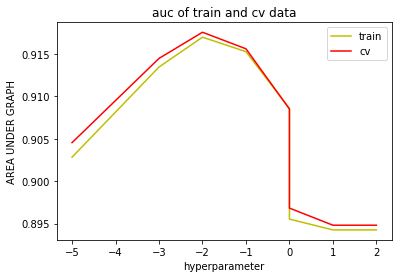

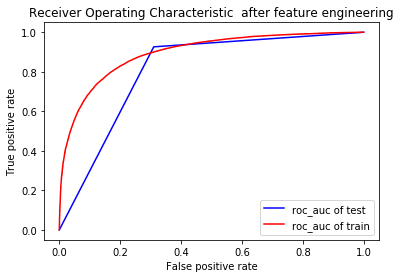

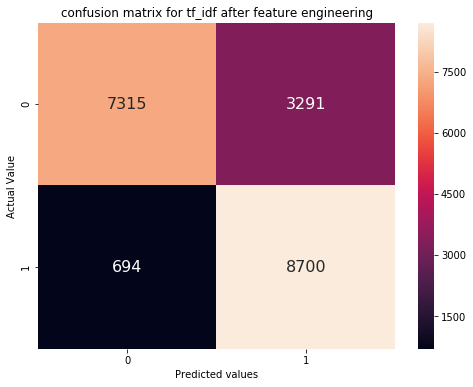

In [421]:
AUCcurve(y1=list_train,y2=list_cv)
ROC_curve(pred_train,pred_test)
confusion(pred_test)

### [5.1.4]  Applying Linear SVM on tfidf-W2V,<font color='red'> SET 4</font>

In [422]:
list_train,list_cv,pred_train,pred_cv,ALPHA,pred_test=SimpleCrossValidation(x_train=tfidf_sent_vectors_train,x_cv=tfidf_sent_vectors_cv,pred_train_data=sent_vectors_train,pred_cv_data=sent_vectors_cv)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 0.0001 is 92.14188063913036
AUC cv SCORE  FOR 0.001 is 93.22624672927256
AUC cv SCORE  FOR 0.01 is 94.31721438691612
AUC cv SCORE  FOR 0.1 is 92.97844890661023
AUC cv SCORE  FOR 1.0 is 88.45845759583915
AUC cv SCORE  FOR 10.0 is 79.45824340471552
AUC cv SCORE  FOR 100.0 is 74.28587551102387
AUC cv SCORE  FOR 1000.0 is 74.28610499072967
train AUC SCORE [0.9604440431226383, 0.966435420419874, 0.9625194111100088, 0.9374930985958595, 0.8855503531006156, 0.794821591894197, 0.7450167868573656, 0.7450192556364992]
 MAX CV AUC SCORE 94.31721438691612


In [426]:
# AUC VALUE FOR BEST HYPERPARAMETER
clf = SGDClassifier(alpha=.01)
clf.fit(tfidf_sent_vectors_train, y_train)

#calibrate model on validation data
clf=CalibratedClassifierCV(clf,cv='prefit')
clf.fit(tfidf_sent_vectors_cv,y_cv)

pred_test_tf_idf= (clf.predict_proba(tfidf_sent_vectors_test))[:,1]
auc_test=roc_auc_score(y_test,pred_test_tf_idf)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(tfidf_sent_vectors_test)

AUC VALUE FOR TEST DATA 89.14802363608021


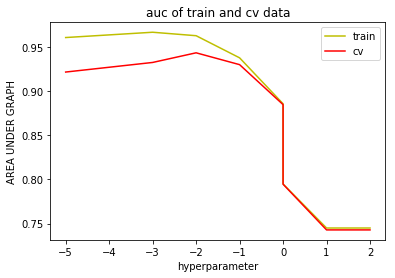

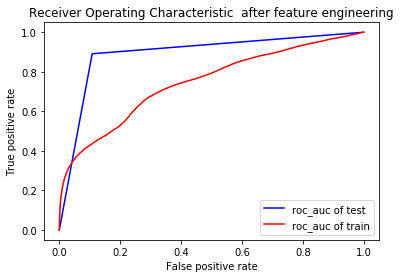

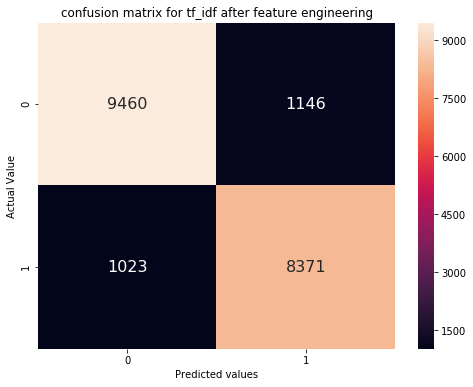

In [424]:
AUCcurve(y1=list_train,y2=list_cv)
ROC_curve(pred_train,pred_test)
confusion(pred_test)

## [5.2] RBF SVM

In [541]:
import math
from sklearn.calibration import CalibratedClassifierCV
from  sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score
alpha=.00001
# Please write all the code with proper documentation
# Please write all the code with proper documentation
import math
from sklearn.calibration import CalibratedClassifierCV
from  sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score

def SimpleCrossValidation_for_rbf_kernel(x_train,x_cv,pred_train_data,pred_cv_data,x_test):
    print("AFTER FEATURE ENGINEERING")
    list_train=[]
    list_cv=[]

    alpha=.00001
    ALPHA=[]
    while (alpha<1000):
        ALPHA.append(math.ceil(math.log(alpha,10)))
       
        clf =SVC(kernel='rbf',gamma='auto',C=alpha,probability=True,class_weight='balanced')
        # fitting the model on crossvalidation traincc
        clf.fit(x_train, y_train)
         
        
        predicted_train=[]
        pred_train=[]
        predicted_cv=[]
        pred_cv=[]
        # predict the response on the train 
       
        for j in range(0,10000,100):
                predicted_train =clf.predict_proba(pred_train_data[j:(j+100)])
                pred_train.extend(predicted_train[:,1])

        # predict the response on the crossvalidation 
        
        for j in range(0,5000,100):
                predicted_cv =clf.predict_proba(pred_cv_data[j:(j+100)])
                pred_cv.extend(predicted_cv[:,1])
        alpha*=10

        # evaluate train accuracy
        auc_train=roc_auc_score(y_train,pred_train)
        #print('AUC train SCORE  FOR', alpha ,'is', auc_train*100)
        list_train.append(auc_train)
    
     
        # evaluate cv accuracy
        auc_cv=roc_auc_score(y_cv,pred_cv)  
        print('AUC cv SCORE  FOR', alpha ,'is', auc_cv*100)
        list_cv.append(auc_cv)
        list_cv_max=max(list_cv)

    print("="*50)
    print("train AUC SCORE",list_train)
    pred_train=pred_train
    print("="*50)
    print(" MAX CV AUC SCORE",list_cv_max*100)
    pred_cv=pred_cv
    #pred_test=predict_test(x_test,x_train)
    return list_train,list_cv,pred_train,pred_cv,ALPHA,clf        

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [542]:
list_train,list_cv,pred_train,pred_cv,ALPHA,pred_test=SimpleCrossValidation_for_rbf_kernel(x_train=train_bow,x_cv=cv_bow,
                                        pred_train_data=train_bow,pred_cv_data=cv_bow, x_test=test_bow)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 0.0001 is 34.57771365006954
AUC cv SCORE  FOR 0.001 is 34.57771365006954
AUC cv SCORE  FOR 0.01 is 34.57770548162844
AUC cv SCORE  FOR 0.1 is 65.43649126899835
AUC cv SCORE  FOR 1.0 is 87.97726363431262
AUC cv SCORE  FOR 10.0 is 89.71557324730985
AUC cv SCORE  FOR 100.0 is 88.57030062640509
AUC cv SCORE  FOR 1000.0 is 86.88421185734177
train AUC SCORE [0.3541399770996885, 0.3541399770996885, 0.3541399770996885, 0.6457312906196395, 0.9122880600726139, 0.9774312722287171, 0.9979841410351104, 0.9999607997256942]
 MAX CV AUC SCORE 89.71557324730985


In [543]:
# AUC VALUE FOR BEST HYPERPARAMETER
clf = SVC(C=100,probability=True)
clf.fit(train_bow, y_train)
pred_test_bow= (clf.predict_proba(test_bow))[:,1]
auc_test=roc_auc_score(y_test,pred_test_bow)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(test_bow)

AUC VALUE FOR TEST DATA 87.65261424535333


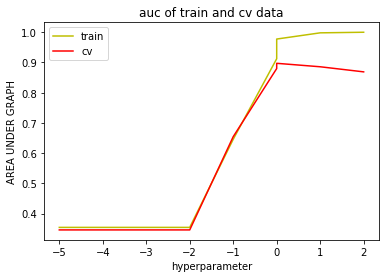

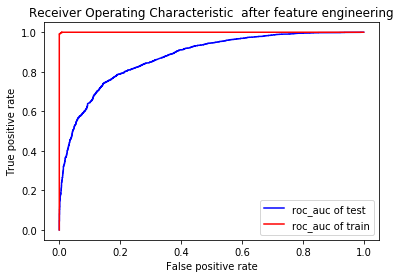

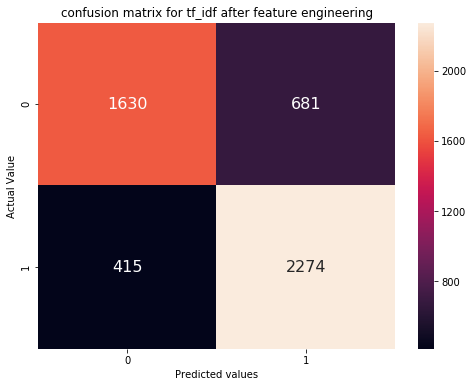

In [544]:
AUCcurve(y1=list_train,y2=list_cv)
ROC_curve(pred_train,pred_test_bow)
confusion(pred_test)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [545]:
list_train,list_cv,pred_train,pred_cv,ALPHA,clf=SimpleCrossValidation_for_rbf_kernel(x_train=train_tf_idf,  x_cv=cv_tf_idf,  pred_train_data=train_tf_idf,  pred_cv_data=cv_tf_idf, x_test=test_tf_idf)


AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 0.0001 is 15.540655229868916
AUC cv SCORE  FOR 0.001 is 15.540655229868916
AUC cv SCORE  FOR 0.01 is 15.540655229868916
AUC cv SCORE  FOR 0.1 is 84.45934477013108
AUC cv SCORE  FOR 1.0 is 88.75179521914211
AUC cv SCORE  FOR 10.0 is 90.09293888911488
AUC cv SCORE  FOR 100.0 is 89.74510216187596
AUC cv SCORE  FOR 1000.0 is 89.62555702641951
train AUC SCORE [0.1277107971255694, 0.1277107971255694, 0.1277107971255694, 0.8722892028744306, 0.9256732098892957, 0.9900975345429184, 0.999986070014405, 0.9992512267263252]
 MAX CV AUC SCORE 90.09293888911488


In [547]:
# AUC VALUE FOR BEST HYPERPARAMETER
clf = SVC(C=10,probability=True)
clf.fit(train_tf_idf, y_train)
pred_test_tf_idf= (clf.predict_proba(test_tf_idf))[:,1]
auc_test=roc_auc_score(y_test,pred_test_tf_idf)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(test_tf_idf)

AUC VALUE FOR TEST DATA 90.76515553936346


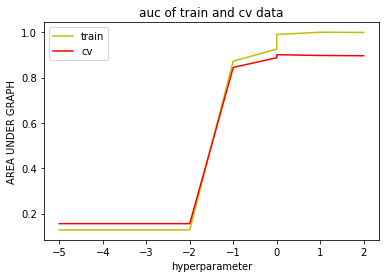

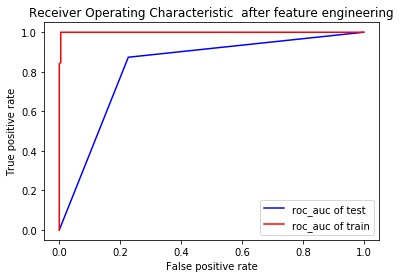

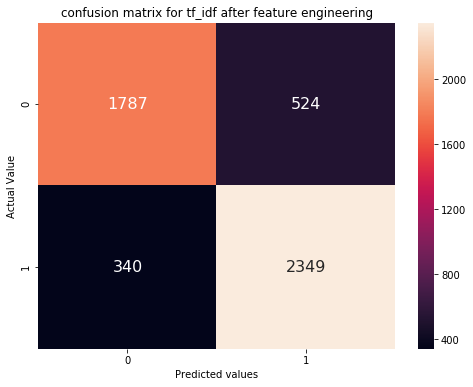

In [548]:
AUCcurve(y1=list_train,y2=list_cv)
ROC_curve(pred_train,pred_test)
confusion(pred_test)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [549]:
list_train,list_cv,pred_train,pred_cv,ALPHA,pred_test=SimpleCrossValidation_for_rbf_kernel(x_train=sent_vectors_train
,x_cv=sent_vectors_cv,pred_train_data=sent_vectors_train,pred_cv_data=sent_vectors_cv,x_test=sent_vectors_test)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 0.0001 is 31.987149735203644
AUC cv SCORE  FOR 0.001 is 31.987149735203644
AUC cv SCORE  FOR 0.01 is 68.01285026479637
AUC cv SCORE  FOR 0.1 is 73.61184286729274
AUC cv SCORE  FOR 1.0 is 82.1237015650243
AUC cv SCORE  FOR 10.0 is 85.17962973763457
AUC cv SCORE  FOR 100.0 is 85.77710219324277
AUC cv SCORE  FOR 1000.0 is 83.66858249284158
train AUC SCORE [0.29554772181246525, 0.29554772181246525, 0.7044522781875346, 0.7542879607457601, 0.8335866279489645, 0.8731352563173739, 0.9129775212636948, 0.953799584222301]
 MAX CV AUC SCORE 85.77710219324277


In [550]:
# AUC VALUE FOR BEST HYPERPARAMETER
clf = SVC(C=100,probability=True)
clf.fit(sent_vectors_train, y_train)
pred_test_sent_vectors= (clf.predict_proba(sent_vectors_test))[:,1]
auc_test=roc_auc_score(y_test,pred_test_sent_vectors)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(sent_vectors_test)

AUC VALUE FOR TEST DATA 82.86634700501861


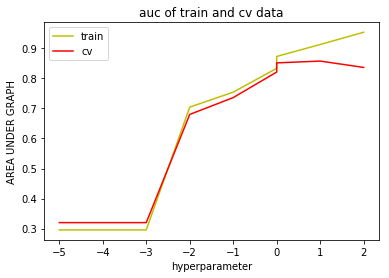

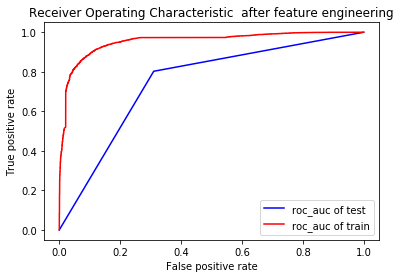

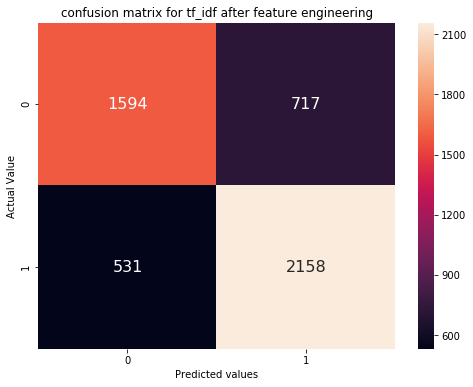

In [551]:
AUCcurve(y1=list_train,y2=list_cv)
ROC_curve(pred_train,pred_test)
confusion(pred_test)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [552]:
list_train,list_cv,pred_train,pred_cv,ALPHA,pred_test=SimpleCrossValidation_for_rbf_kernel(x_train=tfidf_sent_vectors_train,
x_cv=tfidf_sent_vectors_cv,pred_train_data=tfidf_sent_vectors_train,pred_cv_data=tfidf_sent_vectors_cv,x_test=tfidf_sent_vectors_test)

AFTER FEATURE ENGINEERING
AUC cv SCORE  FOR 0.0001 is 35.16338270829239
AUC cv SCORE  FOR 0.001 is 35.16338270829239
AUC cv SCORE  FOR 0.01 is 64.83661729170761
AUC cv SCORE  FOR 0.1 is 69.59381936538075
AUC cv SCORE  FOR 1.0 is 78.96904961331417
AUC cv SCORE  FOR 10.0 is 83.04990476414525
AUC cv SCORE  FOR 100.0 is 84.27407635760717
AUC cv SCORE  FOR 1000.0 is 82.79219861597203
train AUC SCORE [0.32625947641047787, 0.32625947641047787, 0.6737405235895222, 0.7171019164109809, 0.8071737671513731, 0.8576805742779621, 0.9019920464168005, 0.9445364988386736]
 MAX CV AUC SCORE 84.27407635760717


In [553]:
# AUC VALUE FOR BEST HYPERPARAMETER
clf = SVC(C=100,probability=True)
clf.fit(tfidf_sent_vectors_train, y_train)
pred_test_tf_idf= (clf.predict_proba(tfidf_sent_vectors_test))[:,1]
auc_test=roc_auc_score(y_test,pred_test_tf_idf)*100
print('AUC VALUE FOR TEST DATA',auc_test)
pred_test=clf.predict(tfidf_sent_vectors_test)

AUC VALUE FOR TEST DATA 82.66400655651283


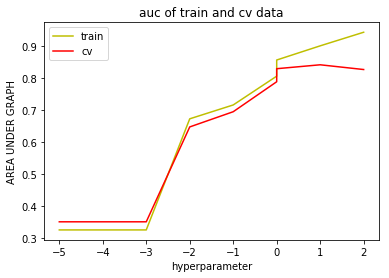

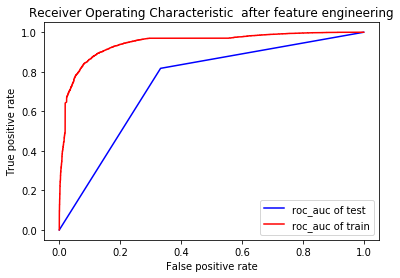

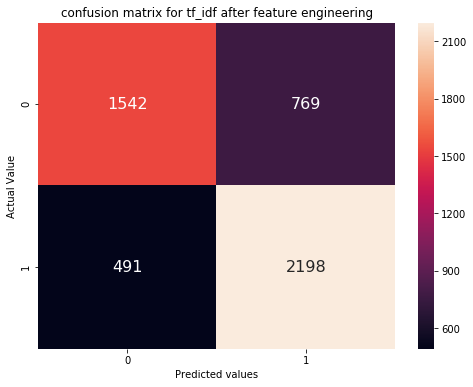

In [554]:
AUCcurve(y1=list_train,y2=list_cv)
ROC_curve(pred_train,pred_test)
confusion(pred_test)

# [6] Conclusions

In [555]:
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer","Model" ,"Hyperparameter","penalty", "AUC"]

x.add_row(["BOW", " linearKERNEL",0.01,"L2" ,86.88])
x.add_row(["TF-IDF"," linearKERNEL",.0001 ,"L2",89.15])
x.add_row(["AVG-W2V"," linearKERNEL",.01,"L2" ,80.74])
x.add_row(["TF-IDF-W2V"," linearKERNEL",.01,"L2",89.14])
x.add_row(["BOW"," RBF-KERNAL",100,"L2",87])
x.add_row(["TF-IDF"," RBF-KERNAL",10 ,"L2",90])
x.add_row(["AVG-W2V"," RBF-KERNAL",100,"L2",82])
x.add_row(["TF-IDF-W2V"," RBF-KERNAL",100 ,"L2",82])


print(x)

+------------+---------------+----------------+---------+-------+
| Vectorizer |     Model     | Hyperparameter | penalty |  AUC  |
+------------+---------------+----------------+---------+-------+
|    BOW     |  linearKERNEL |      0.01      |    L2   | 86.88 |
|   TF-IDF   |  linearKERNEL |     0.0001     |    L2   | 89.15 |
|  AVG-W2V   |  linearKERNEL |      0.01      |    L2   | 80.74 |
| TF-IDF-W2V |  linearKERNEL |      0.01      |    L2   | 89.14 |
|    BOW     |   RBF-KERNAL  |      100       |    L2   |   87  |
|   TF-IDF   |   RBF-KERNAL  |       10       |    L2   |   90  |
|  AVG-W2V   |   RBF-KERNAL  |      100       |    L2   |   82  |
| TF-IDF-W2V |   RBF-KERNAL  |      100       |    L2   |   82  |
+------------+---------------+----------------+---------+-------+
